this script constructs a table records the year, country, discipline, number of papers funding by domestic science, number of papers funding by international science, grants count by sources

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

In [2]:
pub_path = "../../data/NationalFunding/Data/DerivedData/CleanedRawData/pub.pkl"
region_path="../../data/nf_folder/Data/AdditionalData/cntry_region.xlsx"

In [3]:
df = pd.read_pickle(pub_path)

In [4]:
df.sample(2)

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
9686806,53168602,2014,51,1,"[Chile, Australia, Argentina]",[Argentina],"[Argentina, Chile, Australia]",[Argentina],1,1,0,0
9977472,59342618,2016,12,3,[United States],"[United States, United States, United States, ...",[United States],[United States],1,0,0,0


### remove unfunded publications

In [10]:
df=df[df.funder!='Not-Funded']

### assign publications to countries and calculate the number of pub of each country in each dis

In [27]:
pubcntry = df[['id','year','dis','author_distinct','funder']].explode('author_distinct')

In [28]:
pubcnt = pubcntry.groupby(['author_distinct','dis']).size().reset_index(name='pubcnt')
pubcnt.sample()

,author_distinct,dis,pubcnt
11861,Sudan,74,3


In [29]:
pubcntry.sample()

,id,year,dis,author_distinct,funder
12648717,54670389,2014,48,United States,"[United States, Australia, United States, Unit..."


### for the publications authored by each country, calculate the number of each type of grant in each dis of each country

In [30]:
grantcnt = pubcntry.explode('funder').groupby(
    ['author_distinct','dis','funder']).size().reset_index(name='grantcnt')
def assign_type(author, funder):
    if author==funder:
        return "domegrant"
    else:
        return "intgrant"
grantcnt['granttype']=grantcnt.apply(lambda x: assign_type(x.author_distinct,x.funder),axis=1)
grantcnt = grantcnt.groupby(['author_distinct','dis','granttype'])['grantcnt'].sum().reset_index()
grantcnt = grantcnt.pivot_table(
    index=['author_distinct','dis'],columns='granttype',values='grantcnt', fill_value=0).reset_index()

In [33]:
grantcnt.sample()

granttype,author_distinct,dis,domegrant,intgrant
3934,Ethiopia,92,0,1


In [60]:
reg_table = pubcnt.merge(grantcnt,on=['author_distinct','dis'])

In [61]:
unique_counts = reg_table.groupby(['author_distinct']
                 ).agg({'pubcnt':'nunique','domegrant':'nunique','intgrant':'nunique'})

In [62]:
removed_cntrys = unique_counts[(unique_counts==1).any(axis=1)].index

In [63]:
reg_table = reg_table[~reg_table.author_distinct.isin(removed_cntrys)].rename(columns={"author_distinct":'cntry'})

In [64]:
region_df=pd.read_excel(region_path)[['cntry','region2']].drop_duplicates()
region_df=region_df.replace(to_replace={'region2':{'EU':'Europe','Other Europe':'Europe'}})
reg_table=reg_table.merge(region_df,on='cntry',how='left')

In [66]:
reg_table.to_csv("reg_table_grants.csv", index=False)

In [27]:
fundcntry = pubcntry.groupby(['author_distinct','year','dis','fundtype']).size().reset_index(name='fundcnt')
fundcntry = fundcntry.pivot_table(
    index=['author_distinct','year','dis'],columns='fundtype',values='fundcnt', fill_value=0).reset_index()

In [29]:
grantcntry = df[['id','year','dis','author_distinct','funder']].explode('author_distinct')
grantcntry = grantcntry.explode('funder')

In [34]:
grantcntry = grantcntry.groupby(['author_distinct','year','dis','funder']).size().reset_index(name='grantcnt')

In [35]:
grantcntry

,author_distinct,year,dis,funder,grantcnt
0,Afghanistan,2009,35,United Kingdom,1
1,Afghanistan,2009,35,United States,1
2,Afghanistan,2009,48,Japan,1
3,Afghanistan,2009,57,United Kingdom,4
4,Afghanistan,2009,63,United States,1
...,...,...,...,...,...
1124898,Zimbabwe,2018,89,United States,2
1124899,Zimbabwe,2018,91,South Africa,7
1124900,Zimbabwe,2018,96,South Africa,4
1124901,Zimbabwe,2018,96,Zimbabwe,2


In [36]:
def assign_type(author, funder):
    if author==funder:
        return "domegrant"
    else:
        return "intgrant"
grantcntry['granttype']=grantcntry.apply(lambda x: assign_type(x.author_distinct,x.funder),axis=1)

In [38]:
grantcntry = grantcntry.groupby(['author_distinct','year','dis','granttype'])['grantcnt'].sum().reset_index()

In [40]:
grantcntry = grantcntry.pivot_table(
    index=['author_distinct','year','dis'],columns='granttype',values='grantcnt', fill_value=0).reset_index()

In [42]:
pubcnt = df[['id','year','dis','author_distinct']
           ].explode('author_distinct').groupby(['author_distinct','year','dis']).size().reset_index(name='pubcnt')

In [44]:
pubcnt.sample(2)

,author_distinct,year,dis,pubcnt
50196,Madagascar,2012,28,1
61559,Oman,2009,68,5


In [45]:
fundcntry.sample(2)

fundtype,author_distinct,year,dis,domestic,intl
2537,Armenia,2017,98,10,243
78679,Spain,2014,55,7,4


In [47]:
grantcntry.sample(2)

granttype,author_distinct,year,dis,domegrant,intgrant
11094,Bulgaria,2018,82,28,80
40619,Italy,2009,93,185,427


In [56]:
meta_df = pubcnt.merge(fundcntry, on=['author_distinct','year','dis'])
meta_df = meta_df.merge(grantcntry, on=['author_distinct','year','dis'])
meta_df = meta_df.rename(columns={'author_distinct':'cntry','domestic':'domepub','intl':'intlpub'})

In [58]:
region_df=pd.read_excel(region_path)[['cntry','region2']].drop_duplicates()
region_df=region_df.replace(to_replace={'region2':{'EU':'Europe','Other Europe':'Europe'}})
result_df=meta_df.merge(region_df,on='cntry',how='left')

In [60]:
result_df.to_csv("reg_table_comp_sub.csv", index=False)

In [3]:
result_df = pd.read_csv('reg_table_comp_sub.csv')

In [6]:
result_df = result_df.groupby(['cntry','dis']).agg({'pubcnt':'sum','intgrant':'sum','domegrant':'sum'}).reset_index()

In [7]:
result_df

,cntry,dis,pubcnt,intgrant,domegrant
0,Afghanistan,1,14,26,0
1,Afghanistan,2,7,11,0
2,Afghanistan,3,2,2,0
3,Afghanistan,4,4,9,0
4,Afghanistan,12,1,1,0
...,...,...,...,...,...
13978,Zimbabwe,91,1,7,0
13979,Zimbabwe,93,3,6,0
13980,Zimbabwe,94,1,2,0
13981,Zimbabwe,96,8,9,3


<Axes: xlabel='domegrant', ylabel='intgrant'>

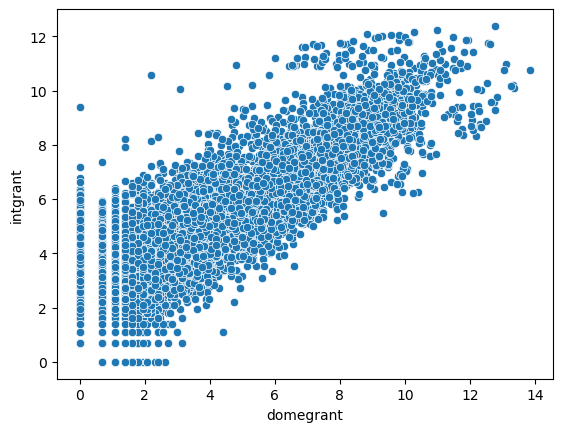

In [8]:
x=np.log(result_df['domegrant']+1)
y=np.log(result_df['intgrant']+1)
sns.scatterplot(x=x,y=y)

In [7]:
test = df.explode('author_distinct')

In [9]:
test[test.author_distinct=='Nauru']

,id,year,dis,type,author,funder,author_distinct,funder_distinct,funded,IntCol,cofund,intfund
1881168,55973420,2015,18,1,"[Australia, Solomon Islands, Nauru]",[China],Nauru,[China],1,1,0,1
9741261,54158746,2015,78,1,[Nauru],"[China, China, China, China, China, China, Chi...",Nauru,[China],1,0,0,1
9860952,59155055,2016,22,1,"[Taiwan, Nauru]",Not-Funded,Nauru,Not-Funded,0,1,0,0
10428184,52744022,2014,72,1,"[Tonga, Papua New Guinea, Cook Islands, Vanuat...","[Australia, Australia]",Nauru,[Australia],1,1,0,0
10815927,52631692,2014,37,1,"[United Kingdom, Netherlands, Nauru, France, N...","[United States, New Zealand]",Nauru,"[New Zealand, United States]",1,1,1,1
